Aluno: Leonardo José Held, 17203984.

Nesse trabalho, vamos explorar os conceitos de sinais e filtragem, mais especificamente com sinais de voz. O sinal de voz utilizado foi gerado por computador, via o plano de estudante da https://www.naturalreaders.com. O texto falado é uma parte da música "Han-tyumi, the Confused Cyborg".

Os filtros abordados serão de esquecimento e média móvel, além de conceitos básicos de correlação de sinais. O código é em linguagem Python e a licença permissiva e aberta para todo o documento pode ser encontrada no final deste arquivo. Além disso, os códigos (interativos :-)!) e arquivos fonte podem ser encontrados em https://github.com/leonheld/explorations-into-dsp/tree/master/first-assignment.

Incluindo algumas bibliotecas, comentários ao lado sobre o que cada uma faz

In [15]:
import wave # para lidar com arquivos WAVE
import numpy as np # arrays, só que mais rápidos e melhores
import scipy.signal as sps # para usar função correlação
import scipy.fftpack as fftp # para gerar um gráfico de espectro de frequência
import matplotlib.pyplot as plt # para gerar plots
import seaborn as sns# plots mais belos, afinal, estética é sempre bom
from IPython.display import Audio # para ter um player de aúdio inline, sem necessidade de um externo

import warnings
warnings.filterwarnings('ignore') # Ignorar os warnings faz o programador ser mais feliz

sns.set_theme()

Essa função separa os canais de aúdio. 
    Copyright Andriy Makukha sob a Creative Commons License

In [16]:
def save_wav_channel(fn, wav, channel):
    # Read data
    nch   = wav.getnchannels()
    depth = wav.getsampwidth()
    wav.setpos(0)
    sdata = wav.readframes(wav.getnframes())

    # Extract channel data (24-bit data not supported)
    typ = { 1: np.uint8, 2: np.uint16, 4: np.uint32 }.get(depth)
    if not typ:
        raise ValueError("sample width {} not supported".format(depth))
    if channel >= nch:
        raise ValueError("cannot extract channel {} out of {}".format(channel+1, nch))
    print ("Extracting channel {} out of {} channels, {}-bit depth".format(channel+1, nch, depth*8))
    data = np.fromstring(sdata, dtype=typ)
    ch_data = data[channel::nch]

    # Save channel to a separate file
    outwav = wave.open(fn, 'w')
    outwav.setparams(wav.getparams())
    outwav.setnchannels(1)
    outwav.writeframes(ch_data.tostring())
    outwav.close()

Trecho de código simples que abre o arquivo .wav e gera um numpy array normalizado
Copyright Matthew Walker sob a Creative Commons License, com modificações

Extracting channel 1 out of 2 channels, 16-bit depth
Extracting channel 2 out of 2 channels, 16-bit depth


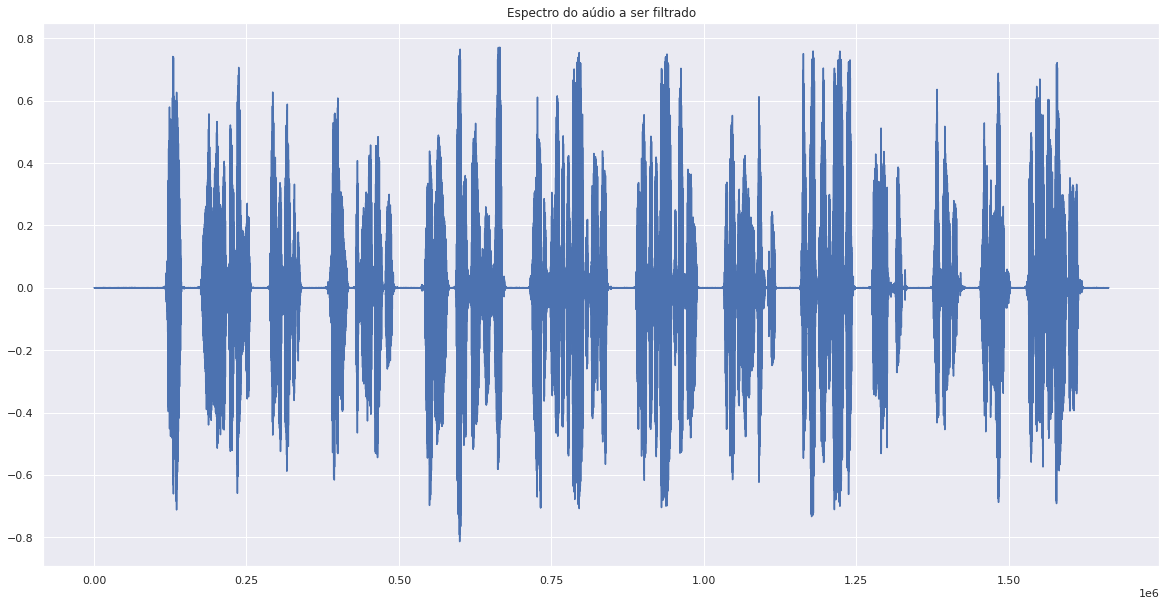

In [17]:
# Read file to get buffer                                                                                               
voiceSampleTwoChannels = wave.open("audioSample.wav")

# Extracting the channels using save_wav_channel() defined above
save_wav_channel('ch1.wav', voiceSampleTwoChannels, 0)
save_wav_channel('ch2.wav', voiceSampleTwoChannels, 1)

voiceSampleFirstChannel = wave.open("ch1.wav")
samples = voiceSampleFirstChannel.getnframes()
audio = voiceSampleFirstChannel.readframes(samples)

# Convert buffer to float32 using NumPy                                                                                 
audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

# Normalise float32 array so that values are between -1.0 and +1.0                                                      
max_int16 = 2**15
audio_normalised = audio_as_np_float32 / max_int16

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised)
plt.title("Espectro do aúdio a ser filtrado")
plt.show()

E esse trecho de código será usado pra plots de espectro de frequência.

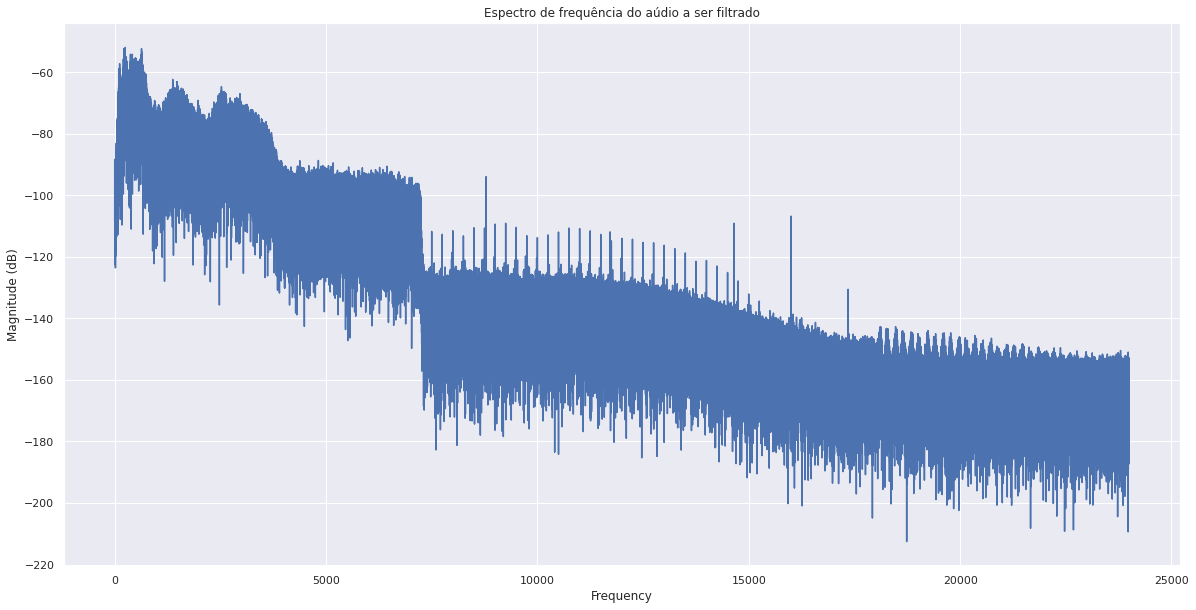

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(audio_normalised, scale='dB', Fs=48000)
plt.title("Espectro de frequência do aúdio a ser filtrado")
plt.show()

# Filtragem com esquecimento

Definição da função de filtro de esquecimento (ou exponential moving average)

In [19]:
def exponential_moving_average(x, alpha):
    if (abs(alpha) > 1 or alpha == 0):
        raise Exception("Módulo de Alpha deve ser maior que 1 e diferente de zero")
    y = np.zeros_like(x)
    for i in range(x.size):
        if i == 0:
          y[i] = x[i]
        else: 
          y[i] = (alpha * y[i - 1]) + x[i]
    return y

Aplicando o filtro no aúdio gerado com diferentes valores de $\alpha$

$\alpha = 0.98$

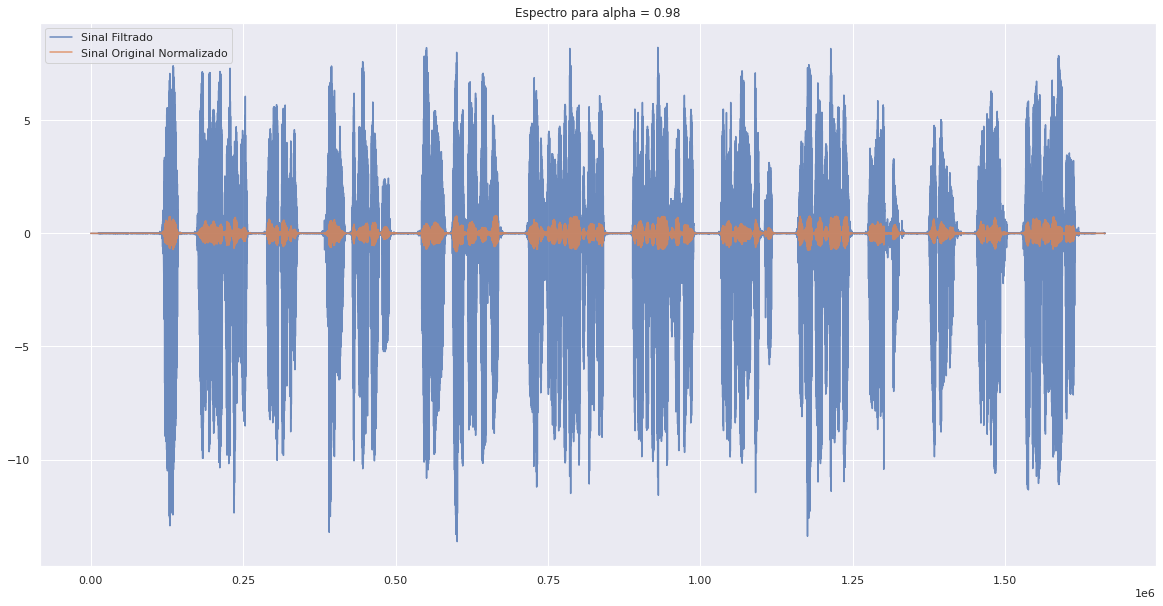

In [20]:
exponential_average_signal = exponential_moving_average(audio_normalised, 0.98)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.legend()
plt.title('Espectro para alpha = 0.98')
plt.show()

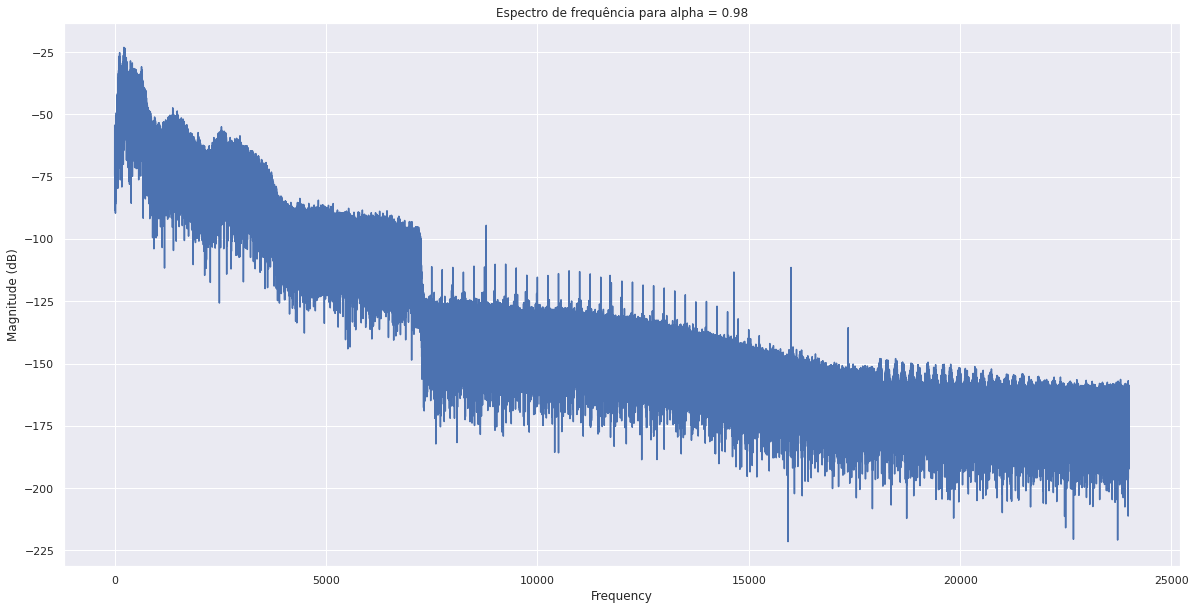

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = 0.98')
plt.show()

$\alpha = 0.5$

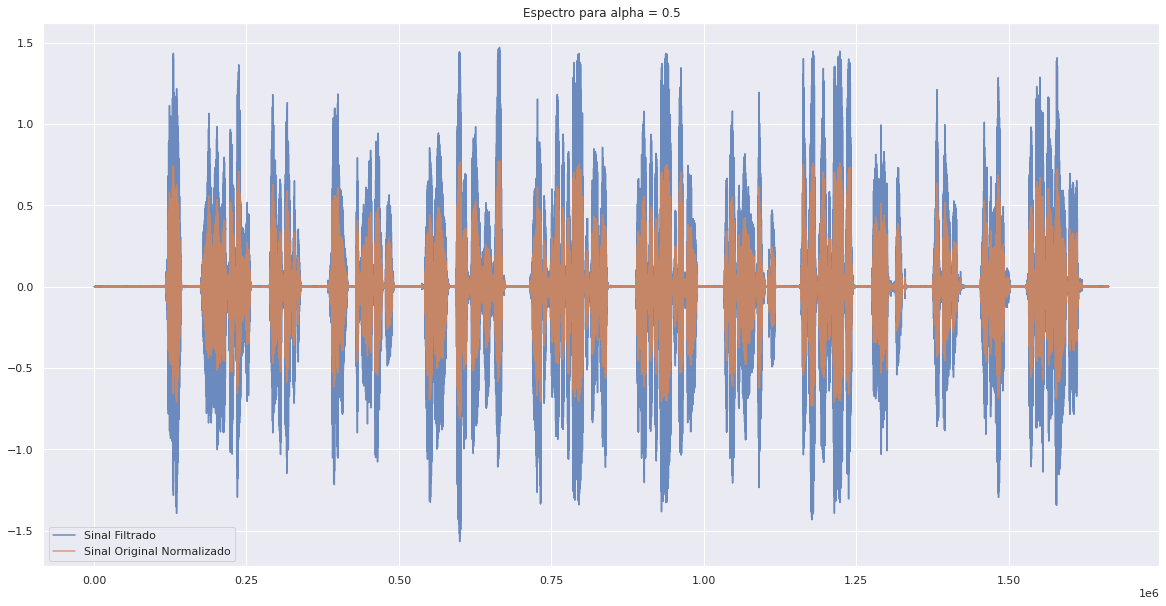

In [22]:
exponential_average_signal = exponential_moving_average(audio_normalised, 0.5)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.legend()
plt.title('Espectro para alpha = 0.5')
plt.show()

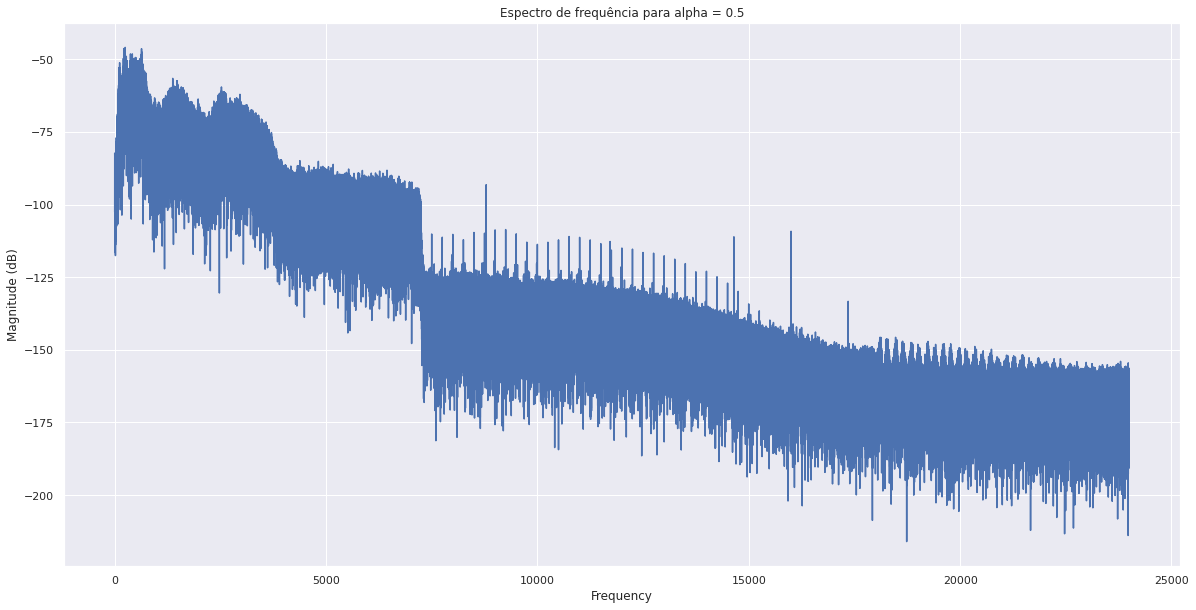

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = 0.5')
plt.show()

$\alpha = -0.98$

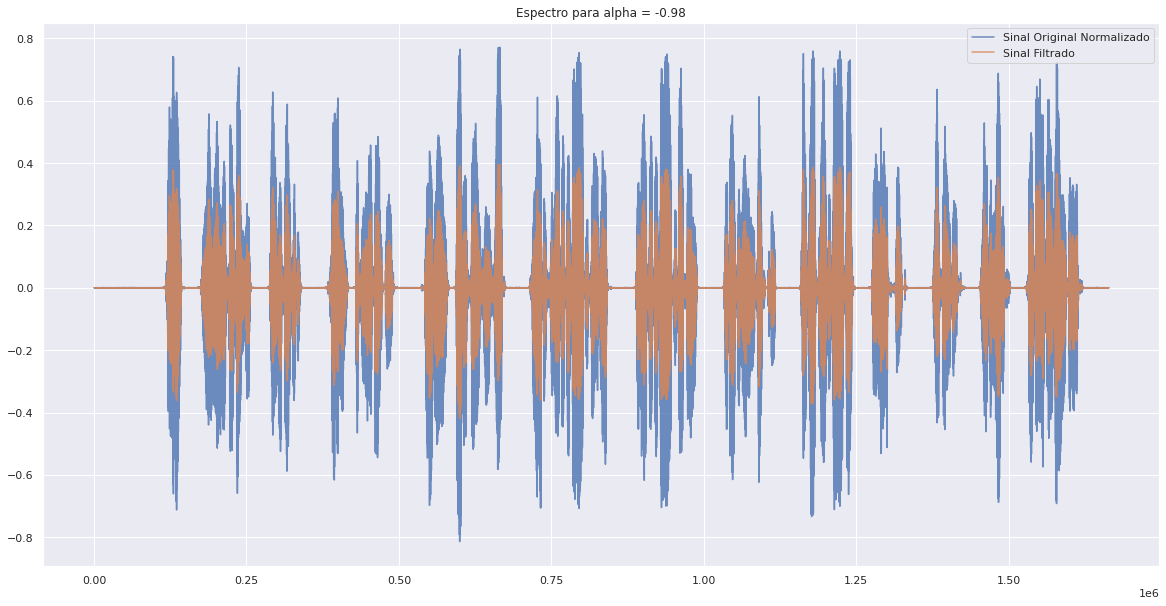

In [24]:
exponential_average_signal = exponential_moving_average(audio_normalised, -0.98)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.title('Espectro para alpha = -0.98')
plt.show()

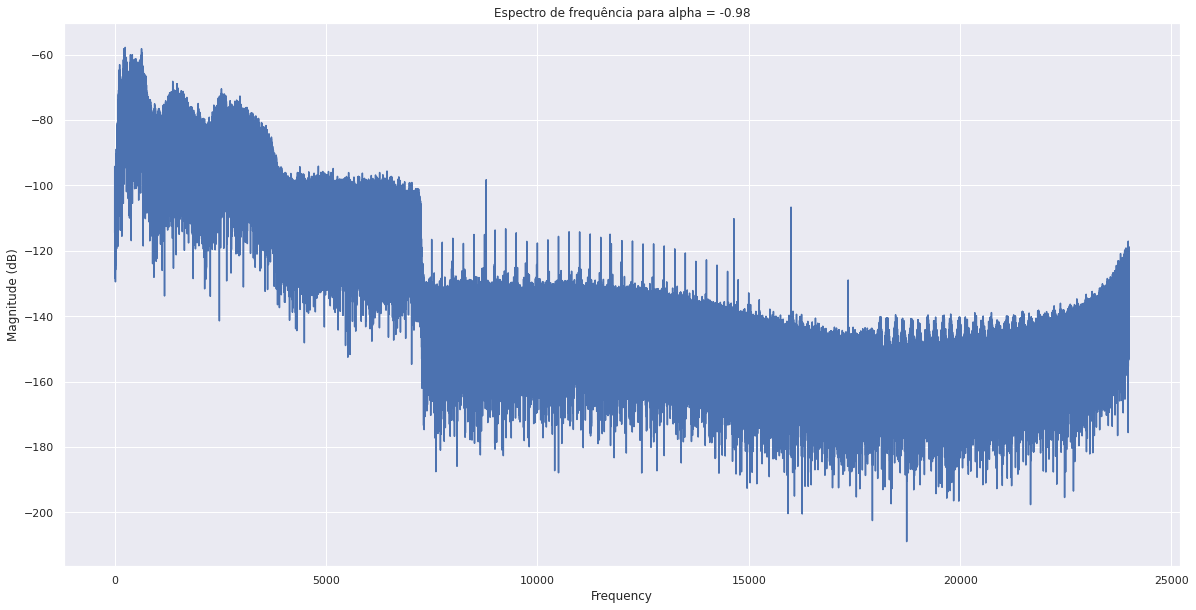

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = -0.98')
plt.show()

$\alpha = -0.5$

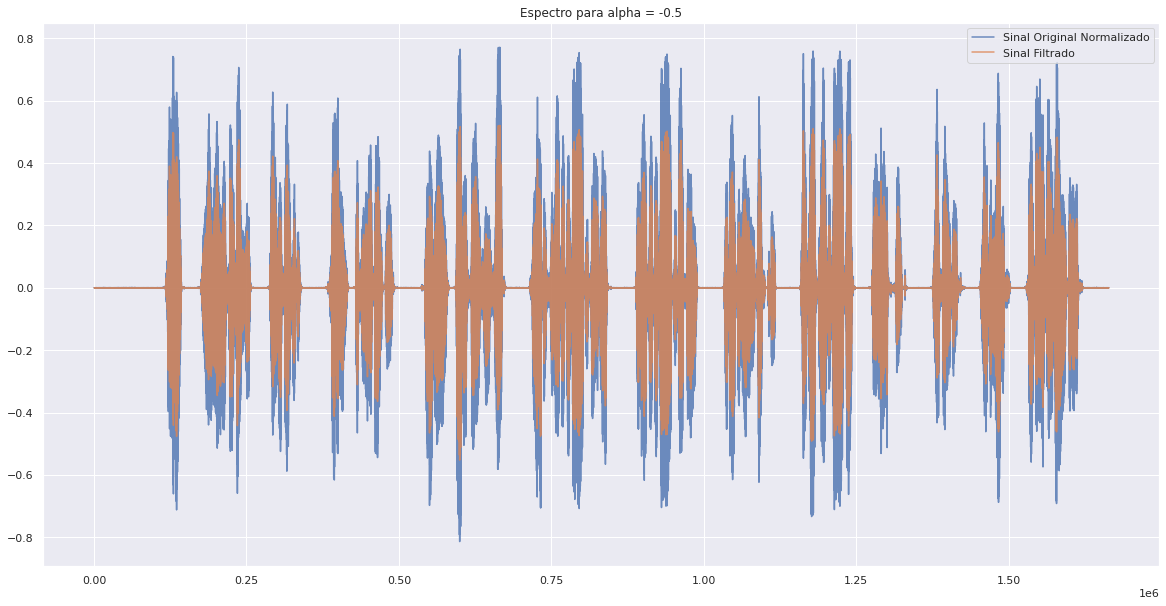

In [26]:
exponential_average_signal = exponential_moving_average(audio_normalised, -0.5)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.title('Espectro para alpha = -0.5')
plt.show()

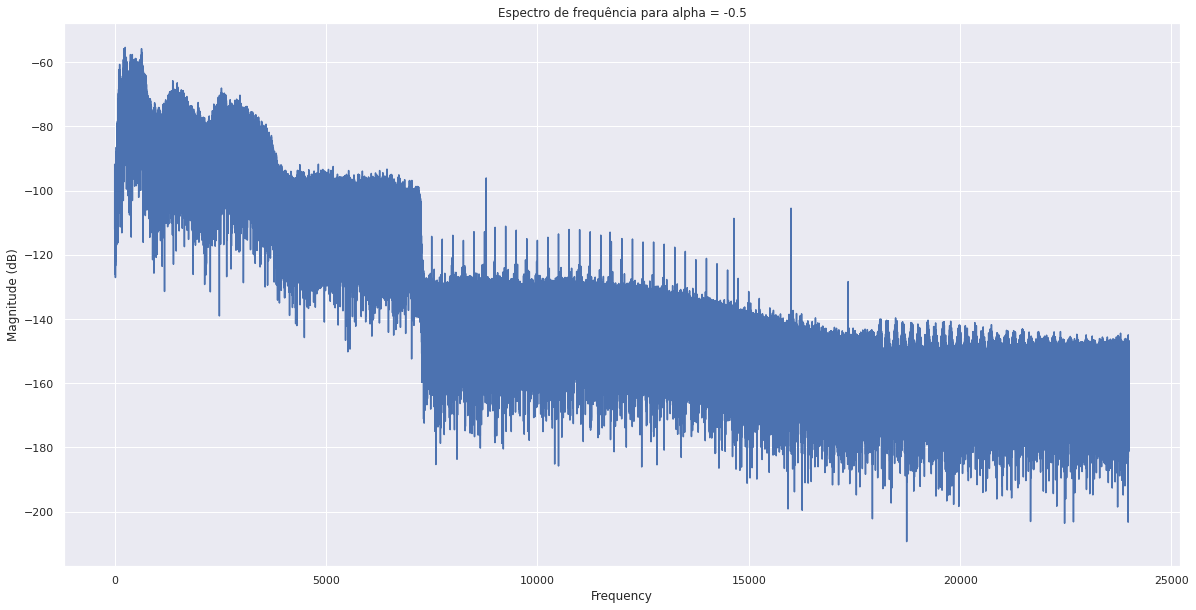

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = -0.5')
plt.show()

$\alpha = -0.2$

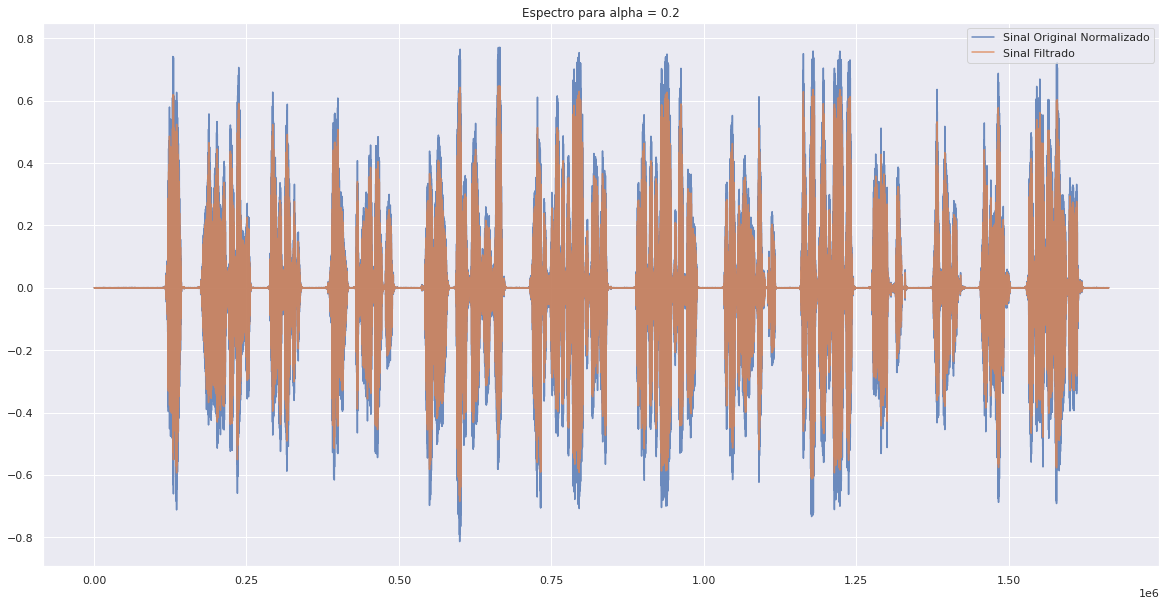

In [28]:
exponential_average_signal = exponential_moving_average(audio_normalised, -0.2)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.title('Espectro para alpha = 0.2')
plt.show()

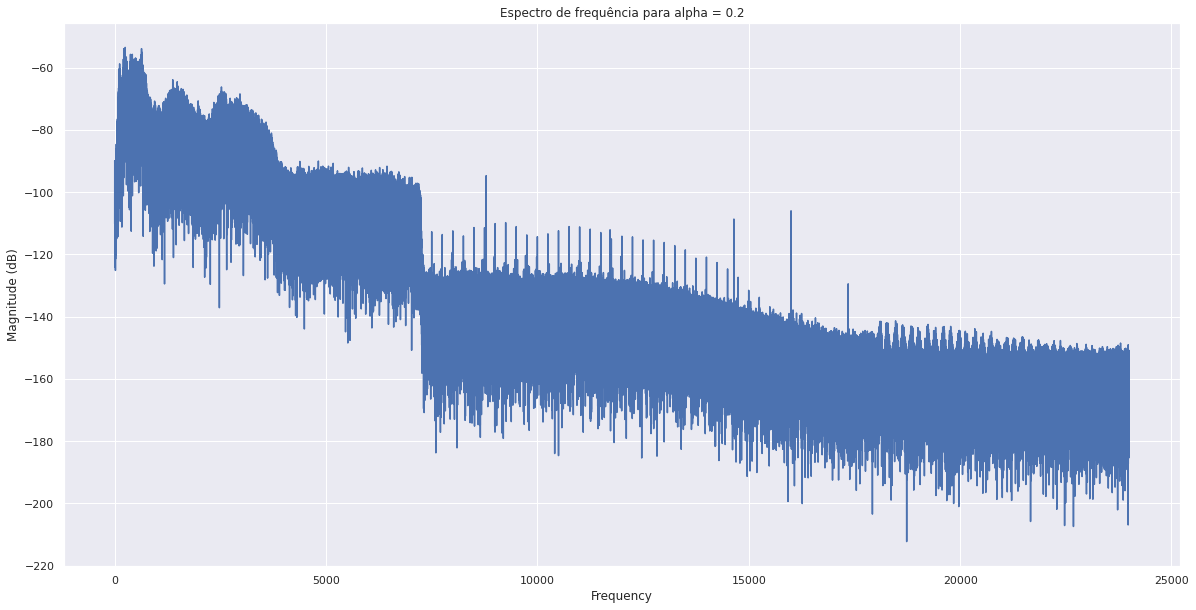

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = 0.2')
plt.show()

$\alpha = 0.1$

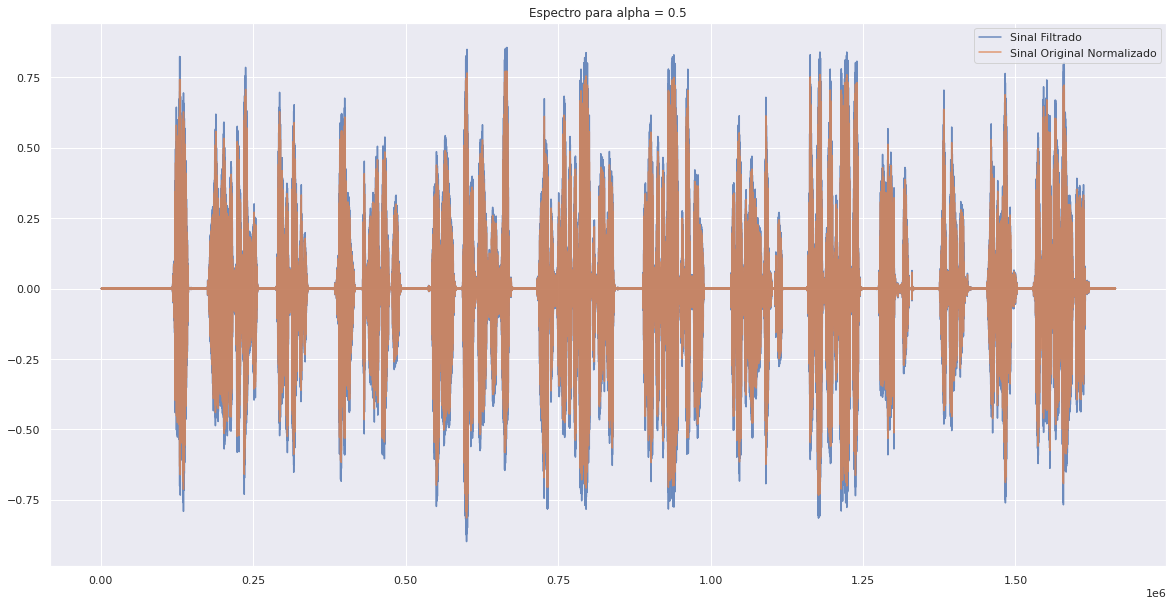

In [30]:
exponential_average_signal = exponential_moving_average(audio_normalised, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(exponential_average_signal, alpha=0.8, label='Sinal Filtrado')
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original Normalizado')
ax.legend()
plt.title('Espectro para alpha = 0.5')
plt.show()

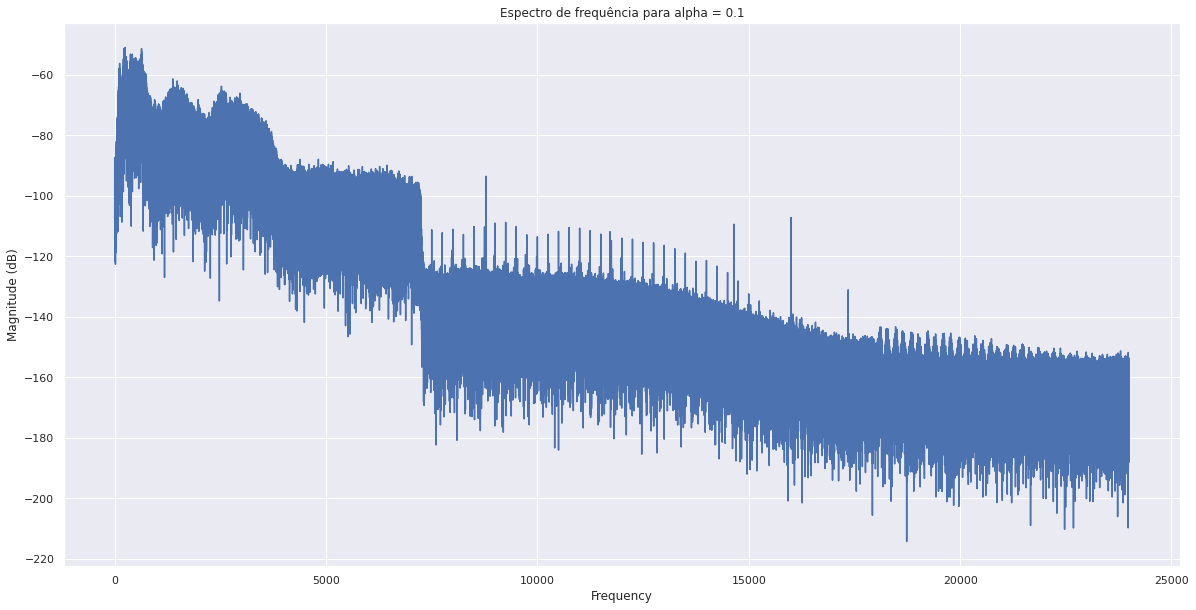

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.magnitude_spectrum(exponential_average_signal, scale='dB', Fs=48000)
plt.title('Espectro de frequência para alpha = 0.1')
plt.show()

# Comentários sobre Filtro de Esquecimento

Com $\alpha = 0.98$, é perceptível o efeito "caixa". A extensão de frequências originais parece ter diminuído, e também houve uma diminuição considerável do volume.

Com $\alpha = 0.5$ houve uma diminuição perceptível no ganho, mas não necessariamente na qualidade e range dinâmica do som original.

Com $\alpha = -0.98$, é perceptível que o filtro funcionou como um passa-alta, dado um distinto som agudo ao aúdio filtrado.

Com $\alpha = -0.5$, não se notou tanta diferença no sinal de saída, mas observando o gráfico é possível ver uma diminuição no ganho, idem para $0.2$ e $-0.1$.






#  Média Móvel

Definição do filtro Média Móvel (ou Simple Moving Average)

In [32]:
def simple_moving_average(x, boxSize):
    if(boxSize < 1):
        raise Exception("O tamanho da janela deve ser maior que um")
    y = np.zeros_like(x)
    for i in range(x.size):
        if i > boxSize:
            y[i] = y[i - 1] + (1/boxSize)*(x[i] - x[i - boxSize])
        else:
            y[i] = y[i - 1] + (1/boxSize)*x[i]
    return y

Como feito para o filtro de esquecimento, aplicaremos o filtro no sinal de voz inicial com diferentes valores para o parâmetro $M$, ou $\texttt{boxSize}$, por facilitação de leitura do código, nesse caso.

$M = 50$

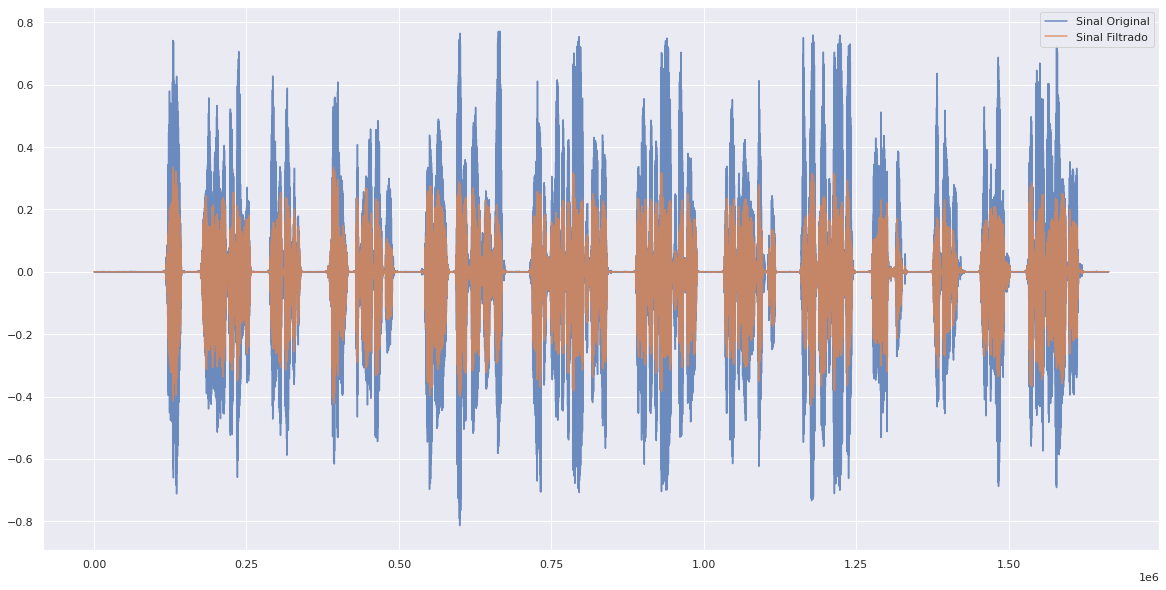

In [33]:
sma_signal = simple_moving_average(audio_normalised, 50)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original')
ax.plot(sma_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.show()

$M = 100$

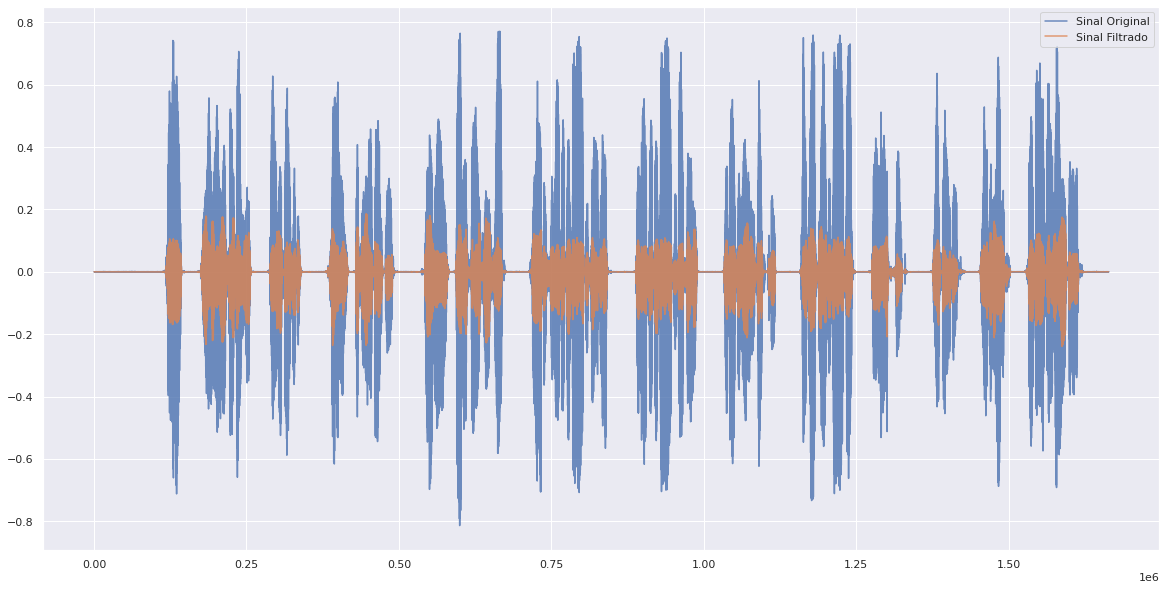

In [34]:
sma_signal = simple_moving_average(audio_normalised, 100)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original')
ax.plot(sma_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.show()

$M = 1000$

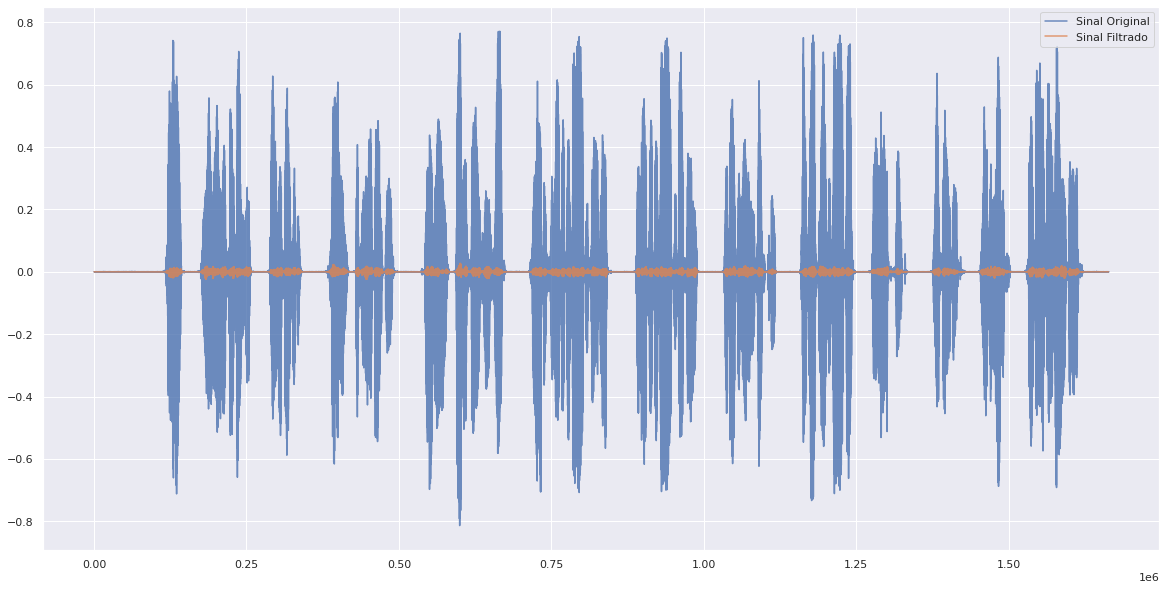

In [35]:
sma_signal = simple_moving_average(audio_normalised, 1000)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original')
ax.plot(sma_signal, alpha=0.8, label='Sinal Filtrado')
ax.legend()
plt.show()

$M = 5$

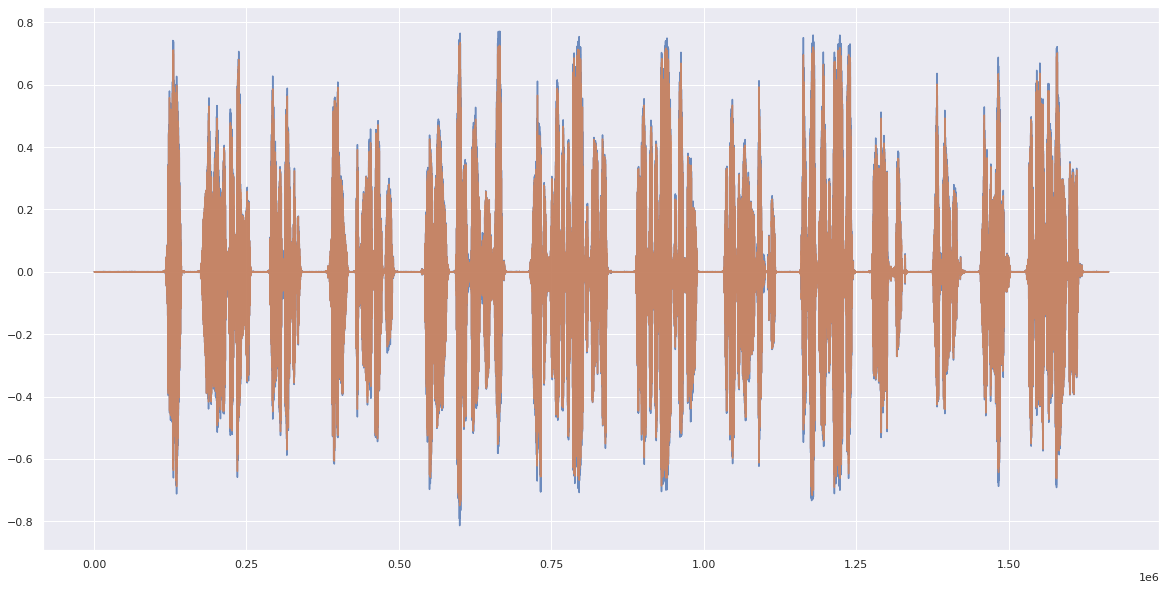

In [36]:
sma_signal = simple_moving_average(audio_normalised, 5)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audio_normalised, alpha=0.8, label='Sinal Original')
ax.plot(sma_signal, alpha=0.8, label='Sinal Filtrado')
plt.show()

# Comentários sobre Média Móvel

Existiu uma clara correlação no "efeito caixa" e o tamanho da janela. Uma suavização geral do som e uma enfatização clara de frequências mais baixas, que progrediu positivamente com o aumento do tamanho da janela.

Para $M = 5$, valor extremamente abaixo dos outros, a diferença é quase imperceptível, dado que entre 5 amostras a diferença entre suas médias não deve ser tão grande assim, o que faz sentido.

# Correlação

Fazendo um slice contendo a palavra "Hello", utilizada abaixo na correlação entre os dois sinais afim de identificar onde acontece a palavra dentro do aúdio maior

In [37]:
hello_slice = audio_normalised[0:int(audio_normalised.size/10)]

E fazendo uma correlação com o sinal inteiro, fica claro pelo pico do gráfico de correlação onde ocorre o slice no sample original.

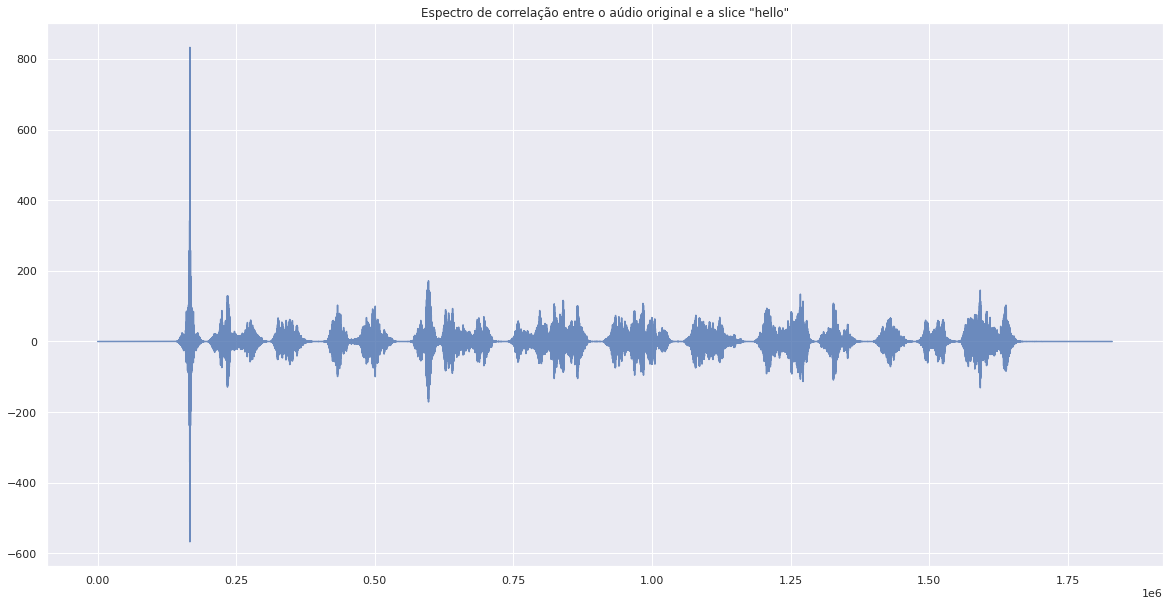

In [38]:
corr = sps.correlate(audio_normalised, hello_slice, mode='full', method='auto')
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(corr, alpha=0.8)
plt.title('Espectro de correlação entre o aúdio original e a slice \"hello\"')
plt.show()

Também é possível gerar uma distorção no sinal original, e refazer a correlação. Talvez isso seja útil pra um sistema de identificação de voz, onde já exista uma gravação prévia da voz de um usuário.

Esse ruído foi adicionado para ser do tipo "pipoca", estourando de tempos em tempos.

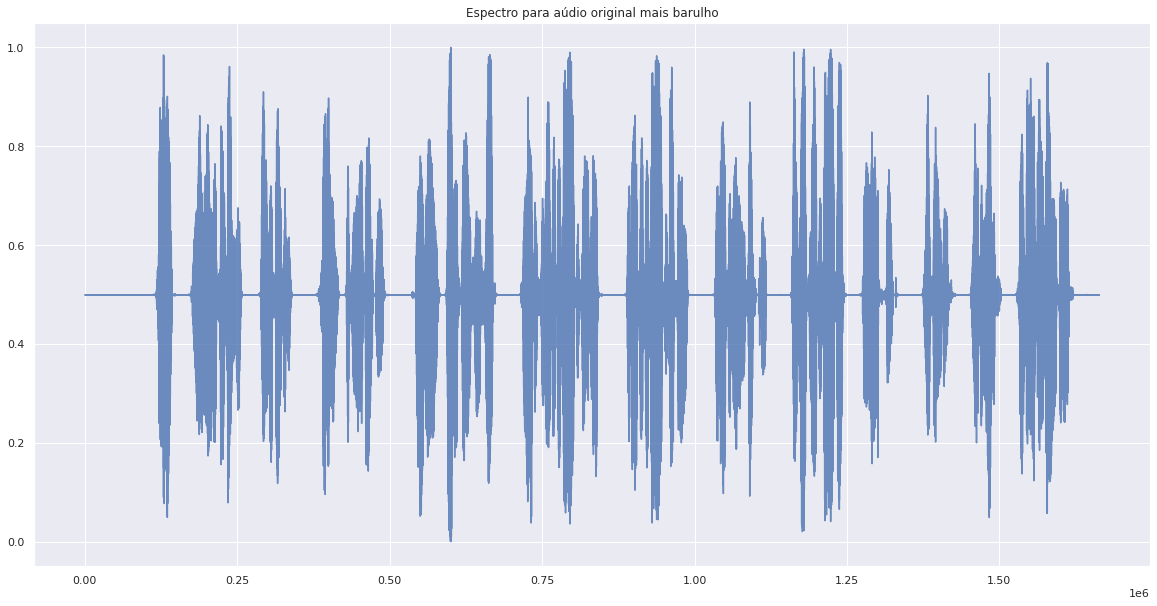

In [39]:
audioWithNoise = np.zeros_like(audio_normalised)
for i in range(audio_normalised.size):
    if i % 5 == 0:
        audioWithNoise[i] = audio_normalised[i]*500
    if i % 3 == 0:
        audioWithNoise[i] = audio_normalised[i]*500
    else:
        audioWithNoise[i] = audio_normalised[i]
audioWithNoise = (audioWithNoise - np.min(audioWithNoise))/np.ptp(audioWithNoise)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(audioWithNoise, alpha=0.8)
plt.title('Espectro para aúdio original mais barulho')
plt.show()

Realizando a correlação é possível ver um pico de 181 (unidades normalizadas) ao redor do início do aúdio.

181.00476


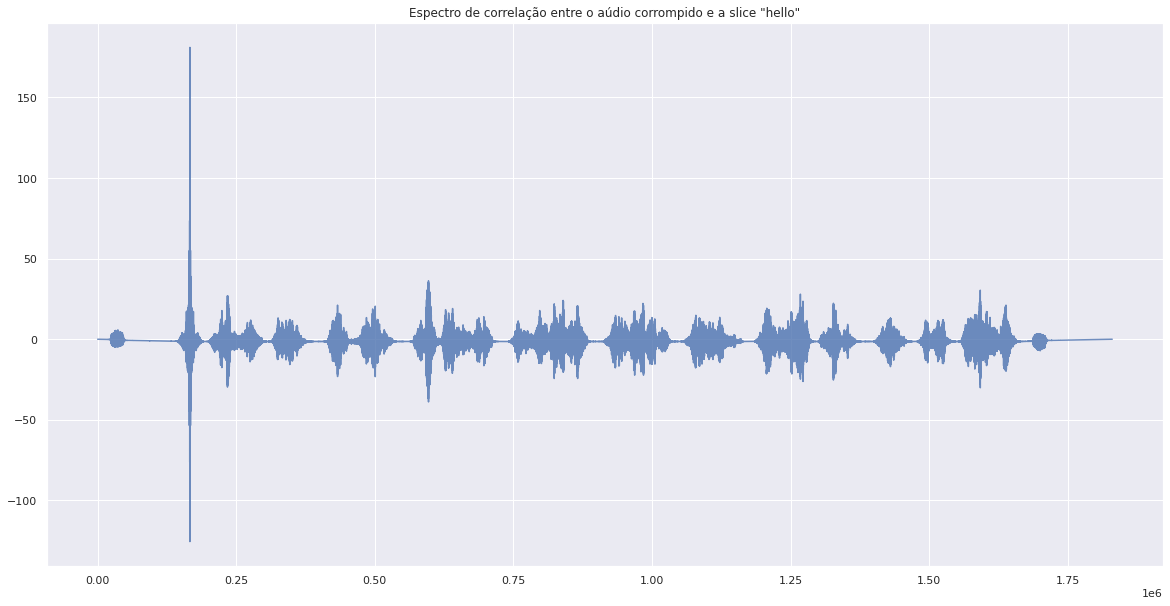

In [40]:
corr_before_filtering = sps.correlate(audioWithNoise, hello_slice, mode='full', method='auto')
print(max(corr_before_filtering))
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(corr_before_filtering, alpha=0.8)
plt.title('Espectro de correlação entre o aúdio corrompido e a slice \"hello\"')
plt.show()

Realizamos então uma filtragem com um filtro de esquecimento, afim de retirar os componentes de barulho pipocante inseridos anteriormente.

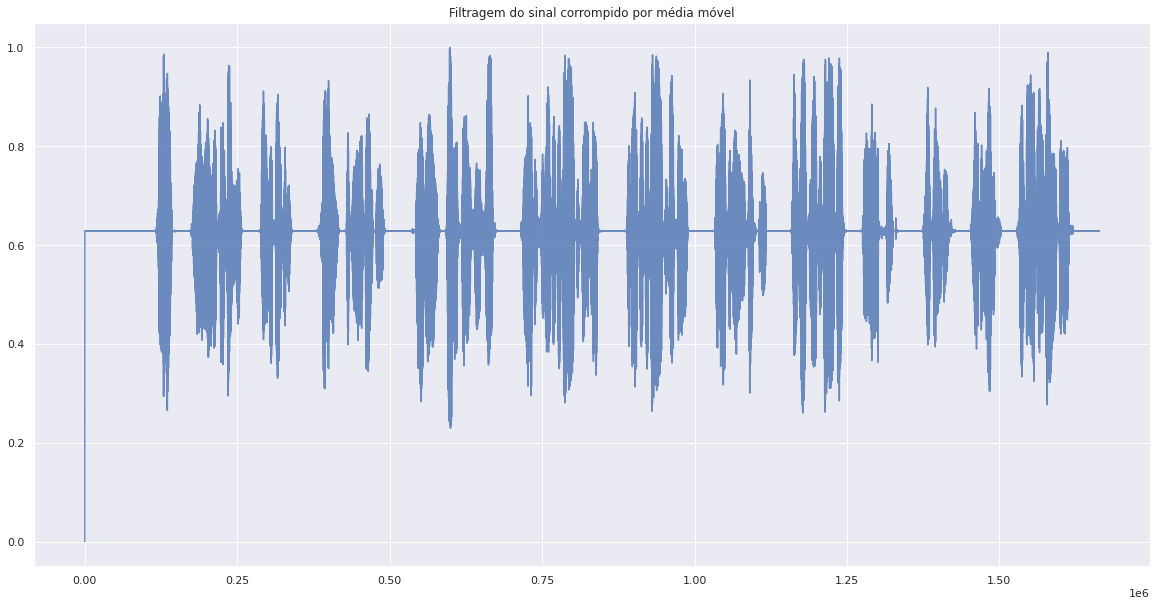

In [41]:
exponential_average_signal = exponential_moving_average(audioWithNoise, .70)
exponential_average_signal = (exponential_average_signal - np.min(exponential_average_signal))/np.ptp(exponential_average_signal)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(exponential_average_signal, alpha=0.8)
plt.title('Filtragem do sinal corrompido por média móvel')
plt.show()

E refazemos a correlação, indicando agora um pico de 312 (unidades normalizadas), ou seja: o filtro ajudou a melhorar a quantificação da correlação entre os dois sinais. Um caso bem leve, mas que demonstra bem o princípio.

312.50626


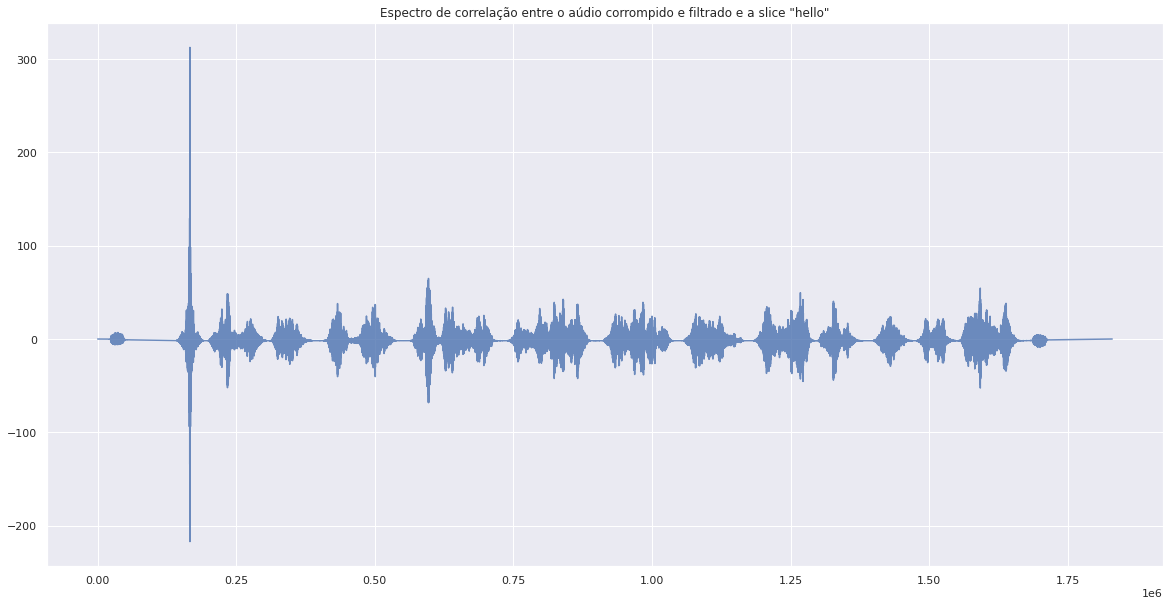

In [42]:
corr_after_filtering = sps.correlate(exponential_average_signal, hello_slice, mode='full', method='auto')
print(max(corr_after_filtering))
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(corr_after_filtering, alpha=0.8)
plt.title('Espectro de correlação entre o aúdio corrompido e filtrado e a slice \"hello\"')
plt.show()

Ou observar a superposição de ambas correlações, que mostra que depois do filtro, a correlação entre o slice e o sinal de fato aumenta.

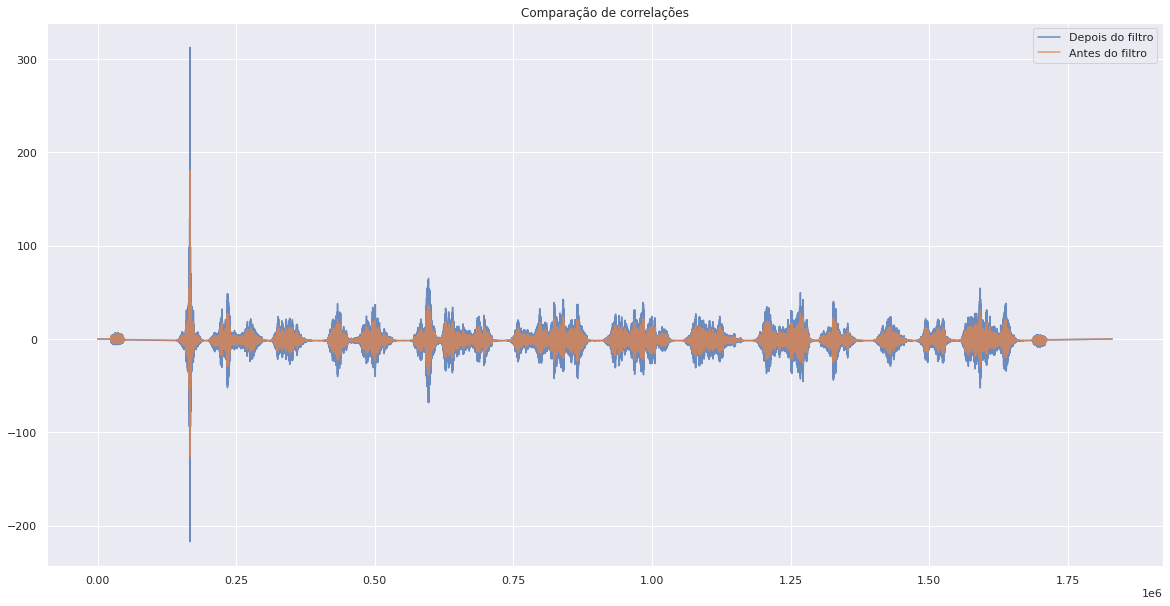

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(corr_after_filtering, alpha=0.8, label='Depois do filtro')
ax.plot(corr_before_filtering, alpha=0.8, label='Antes do filtro')
plt.title('Comparação de correlações')
ax.legend()
plt.show()

# Licença

Todo código, a não ser quando explicitamente citado, está sob a licença livre e permissiva MIT:

Copyright 2021 Leonardo J. Held

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.